In [6]:
__author__ = 'mengyue'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.cm as cm
import mplcyberpunk
import time
import wordcloud

from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE, MDS


# Data Loading

In [7]:
papers = np.loadtxt('archive/NIPS_1987-2015.csv', dtype = np.str, delimiter=',')
print('The shape of original dataset is', papers.shape)
#papers[0:4, :]

The shape of original dataset is (11464, 5812)


# Data Processing

In [8]:
# Remove the useless '' in the word string
def remove(word):
    word_removed = [i.strip('"') for i in word]
    return word_removed

# words containes all words used by all this nips papaer
words = remove(papers[1:,0].tolist())
# pure_count is the word_paper coappeareance matrix
pure_count = papers[1:, 1:].astype(np.float)
# word_count records a specific word is used in how many papers
word_count = pure_count.sum(axis=1)
# paer_count records how many words is used by a specific paper
paper_count = pure_count.sum(axis=0)

#delete papers with no words
paper_delete_idx = np.arange(len(paper_count))[paper_count==0]
paper_idx = remove(np.delete(papers[0,1:], paper_delete_idx))

paper_years = [i[:4] for i in paper_idx]
years = sorted(list(set(paper_years)))
print('The year duration of nips conference is',len(years))

The year duration of nips conference is 29


In [9]:
print('Shape of paper_years', len(paper_years))

Shape of paper_years 5804


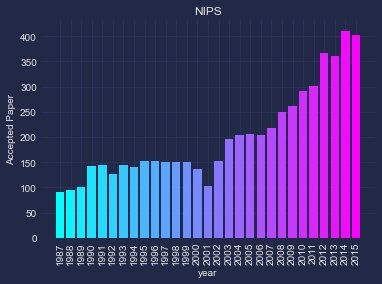

In [10]:
# make the colormap
color_to_map = np.linspace(0, 1, len(years))
colors = [cm.cool(x) for x in color_to_map]

plt.style.use('cyberpunk')
paper_years_values = Counter(paper_years).values()
plt.bar(range(len(years)), paper_years_values, color=colors)
plt.xticks(range(len(years)),years, rotation= 90)
plt.xlabel('year')
plt.ylabel('Accepted Paper')
plt.title('NIPS')
mplcyberpunk.add_glow_effects()
plt.savefig('AcceptedPaper.eps')

In [11]:
data = np.delete(papers[1:, 1:], paper_delete_idx, axis=1).astype(np.float).T

In [12]:
num_topics = 5
num_words = 6

In [13]:
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=50, evaluate_every=1, n_jobs=1)
paper_topics = lda.fit_transform(data)
top_topics = lda.components_
# print('The shape of data fitted by lda is {}'.format(paper_topics.shape))
# print('The shape of top topics is {}'.format(top_topics.shape))

def get_top_n_topics(topics, n):
    return topics.argsort()[:-n-1:-1]

with open('TopTopics.txt', 'a+') as f:
    f.readline()
    for i, topic in enumerate(top_topics):
        f.write('top_index:{}'.format(i))
        for j in get_top_n_topics(topic, num_words):
            f.write(words[j]+' ')
        f.write('\n')

In [14]:
print('The shape of transformed by lda is {}'.format(paper_topics.shape))
print('The shape of components_ of lda is {}'.format(top_topics.shape))
np.save('paper_topics', paper_topics)
np.save('top_topics', top_topics)

The shape of transformed by lda is (5804, 5)
The shape of components_ of lda is (5, 11463)


# Topic Change by Year

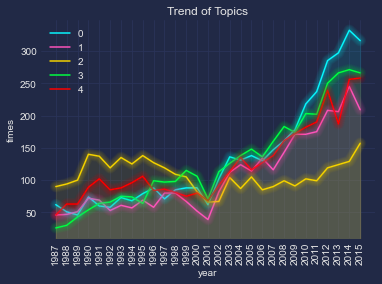

In [15]:
# top_n records the idx of top_n topic for each paper
# shape = num_papers*n
n = 3
top_n = paper_topics.argsort(axis=1)[:,:-n-1:-1]
year_topic_count = {}
#print('The shape of top n topics for each paper is',top_n.shape)

# Initialize the year_topic counting dictionary
for i in range(num_topics):
    for year in years:
        year_topic_count.setdefault(year+'_'+str(i), 0)
#print('Shape of year_topic_count after initialization',len(year_topic_count))

# Counting by year first
# Conducting the year_topic counting      
for year, top in zip(paper_years, top_n):
    for top_idx in top:
        year_topic_count[year+'_'+str(top_idx)]+=1
        
# topic i of year 19xx will be added by 1 iff the topic i appears as the top-n topic in 
# one paper published in year 19xx
#print('Shape of year_topic_count after counting',len(year_topic_count))
#print(year_topic_count)

# Counting by topic first
t = 0
counts = list(year_topic_count.values())
for i in range(num_topics):
    exec('topic_{}_count_by_year=[]'.format(str(i)))
    for j in range(len(years)):
        count = counts[t]
        eval('topic_{}_count_by_year.append({})'.format(str(i), count))
        t += 1
"""
print(len(topic_1_count_by_year))
print(len(topic_2_count_by_year))
print(len(topic_3_count_by_year))
print(topic_0_count_by_year)
print(topic_1_count_by_year)
"""    

# print('len of years',len(years))

plt.style.use('cyberpunk')
x = np.arange(len(years))
plt.figure(1)
for i in range(num_topics):
    exec('plt.plot(x, topic_{}_count_by_year, label={})'.format(i, i))
    
plt.xticks(x, years, rotation = 90)
plt.xlabel('year')
plt.ylabel('times')
plt.title('Trend of Topics')
plt.legend(loc = 'best')
mplcyberpunk.add_glow_effects()
plt.savefig('topByYear.pdf', dpi=4180)

# Visualizaiton by 8 methods

In [16]:
# Topic Category of each doc
document_y = np.argmax(paper_topics, axis=1)
# Topic Category of each word
word_y = np.argmax(top_topics.T, axis=1)

# make colormap
color_to_map = np.linspace(0, 1, num_topics)
colors = [cm.cool(x) for x in color_to_map]

# Find color for each document
document_color = []
for i in range(len(document_y)):
    document_color.append(colors[document_y[i]])

# Find color for each document
word_color = []
for i in range(len(word_y)):
    word_color.append(colors[word_y[i]])

Method used LLE
Method used LTSA
Method used Hessian LLE
Method used Modified LLE
Method used Isomap
Method used SpectralEmbedding


/opt/anaconda3/envs/MATH5473/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/opt/anaconda3/envs/MATH5473/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Method used PCA
Method used MDS


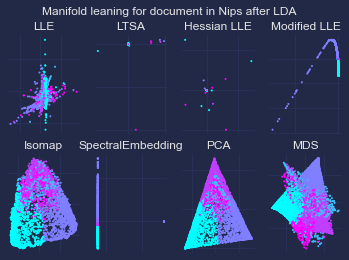

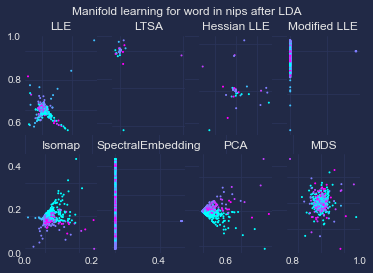

In [17]:
methods = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE', 'Isomap', 'SpectralEmbedding', 'PCA', 'MDS']
LLE_dict = dict(zip(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE'],
                   ['standard', 'ltsa', 'hessian', 'modified']))

fig_document = plt.figure(2)
fig_document.suptitle('Manifold leaning for document in Nips after LDA')
fig_word = plt.figure(3)
fig_word.suptitle('Manifold learning for word in nips after LDA')

# make the colormap
#color_to_map = np.linspace(0, 1, len(methods))
#colors = [cm.tab20(x) for x in color_to_map]

for i, method in enumerate(methods):
    print("Method used {}".format(method))
    if method in LLE_dict.keys():
        manifold = LocallyLinearEmbedding(n_neighbors=6, method=LLE_dict[method], eigen_solver='dense')
    elif method == 'MDS':
        manifold = MDS(n_init=1, max_iter=100)
    elif method == 'PCA':
        manifold = PCA(n_components=2)
    else:
        exec('manifold={}(n_neighbors=6)'.format(method))

    document_2D = manifold.fit_transform(paper_topics)
    np.save('document_2D_{}'.format(method), document_2D)
    word_2D = manifold.fit_transform(top_topics.T)
    np.save('word_2D_{}'.format(method), word_2D)
    
    
    plt.style.use('cyberpunk')
    # Plot for document_2D
    ax = fig_document.add_subplot(241+i)
    ax.scatter(document_2D[:, 0], document_2D[:, 1], s=1, c=document_color)
    ax.set_title(method)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    mplcyberpunk.add_glow_effects()
    
    plt.style.use('cyberpunk')
    # Plot for word_2D
    ax = fig_word.add_subplot(241+i)
    ax.scatter(word_2D[:, 0], word_2D[:, 1], s=1, c=word_color)
    ax.set_title(method)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    mplcyberpunk.add_glow_effects()
      
fig_document.savefig('Manifold_for_documents_new.eps')
fig_word.savefig('Manifold_for_word_new.eps')

# Visualization by t-SNE

In [18]:
paper_topics = np.load('paper_topics.npy')
top_topics = np.load('top_topics.npy')

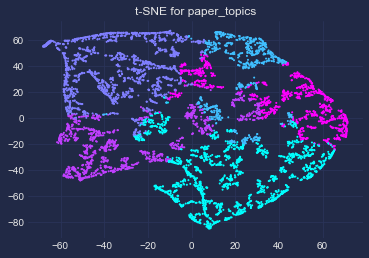

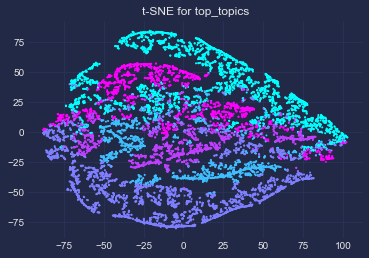

In [19]:
manifold = TSNE(n_components = 2, random_state =2021)

document_2D = manifold.fit_transform(paper_topics)
np.save('document_2D_TSNE', document_2D)
word_2D = manifold.fit_transform(top_topics.T)
np.save('word_2D_TSNE', word_2D)


plt.style.use('cyberpunk')
fig_document, ax = plt.subplots()
ax.set_title('t-SNE for paper_topics')
ax.scatter(document_2D[:, 0], document_2D[:, 1], s=1, c=document_color)
mplcyberpunk.add_glow_effects()
fig_document.savefig('tSNE_for_paper_topics_new.pdf')
plt.show()


plt.style.use('cyberpunk')
fig_word, ax = plt.subplots()
ax.set_title('t-SNE for top_topics')
ax.scatter(word_2D[:, 0], word_2D[:, 1], s=1, c=word_color)
mplcyberpunk.add_glow_effects()
fig_word.savefig('tSNE_for_top_topics_new.pdf')
plt.show()

In [36]:
print(colors)

[(0.0, 1.0, 1.0, 1.0), (0.25098039215686274, 0.7490196078431373, 1.0, 1.0), (0.5019607843137255, 0.4980392156862745, 1.0, 1.0), (0.7529411764705882, 0.24705882352941178, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0)]
